In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import date
import datetime
import time

from scipy.stats import poisson

import nba_api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import boxscoreplayertrackv2
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import teamgamelogs
from nba_api.stats.endpoints import teamandplayersvsplayers

import emcee
import corner

import pickle

import seaborn as sns
sns.set()

In [2]:
#Elo class
class EloSystem:
    def __init__(self, k=20):
        self.ratings = {}
        self.k = k
        
    def addPlayer(self, id, rating=1500):
        self.ratings[id]=rating
        
    def expectResult(self, p1, p2):
        exp = (p2-p1)/400.0
        return 1/((10.0**(exp))+1)
    
    def expectTeamResult(self, t1, t2):
        return self.expectResult(self.getTeamRating(t1),self.getTeamRating(t2))
    
    def addPlayers(self, playerids):
        for p in playerids:
            self.addPlayer(p)

    def getTeamRating(self, players):
        for p in players:
            if p not in self.ratings:
                self.addPlayer(p)
        return np.average([self.ratings[x] for x in players])
    
    def addTeamResult(self, winner, loser, winScore=0, loseScore=0):
        winRating = self.getTeamRating(winner)
        loseRating = self.getTeamRating(loser)
        result = self.expectResult(winRating, loseRating)
        for w in winner:
            self.ratings[w] += self.k*(1-result)
        for w in loser:
            self.ratings[w] += self.k*(1-result)
    
    def getAllRatings(self):
        return self.ratings
    
    def getRating(self, id):
        return self.ratings[id]

In [27]:
#Initialize
elo = EloSystem()
player_dict = players.get_players()

In [4]:
#2015-2016 regular season start and end dates
start_15_16 = '2015-10-27'
end_15_16 = '2016-04-13'
#2016-2017 regular season start and end dates
start_16_17 = '2016-10-25'
end_16_17 = '2017-04-12'
#2016-2017 regular season start and end dates
start_17_18 = '2017-10-17'
end_17_18 = '2018-04-11'
#2018-2019 regular season start and end dates
start_18_19 = '2018-10-16'
end_18_19 = '2019-04-10'

In [5]:
#dates defining training and testing sets
start_15_16_train = '2015-10-27'
end_15_16_train = '2016-02-1'

start_15_16_test = '2016-02-2'
end_15_16_test = '2016-04-13'

In [6]:
teams_df = pd.DataFrame(teams.get_teams())
teams_df.rename(columns={'id':'TEAM_ID'}, inplace=True)
teams_df.head()

,TEAM_ID,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966


In [10]:
# Get **all** the games so we can filter to an individual GAME_ID
result = leaguegamefinder.LeagueGameFinder()
all_games = result.get_data_frames()[0]


In [11]:
#match NBA teams from 'teams_df' with 'all_games' to remove
#all non NBA-games from 'all_games' 
nba_games = pd.merge(teams_df, all_games, on = 'TEAM_ID', how = 'inner')


In [12]:
#function searches rows in 'nba_games' df sharing same 'GAME_ID' and sums PTS
#to obtain sum of final score
def total_pts_game(id_game):
    return np.sum(nba_games.loc[nba_games['GAME_ID'] == str(id_game)][['PTS']])

In [13]:
#uses 'total_pts_game' function to create df of sum of final score for
#all games in 'nba_games' df
total_points = pd.DataFrame(list(map(lambda x : total_pts_game(nba_games['GAME_ID'][x]), list(range(len(nba_games))))))

In [14]:
#appends new column to 'nba_games' df containing combined final score per game
nba_games['COMBINED_FINAL_SCORE'] = total_points
nba_games.head()

,TEAM_ID,full_name,abbreviation,nickname,city,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,COMBINED_FINAL_SCORE
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,Atlanta Hawks,...,15,38,53,26,6,3,17,25,0.0,267
1,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,Atlanta Hawks,...,12,41,53,33,1,5,15,26,5.0,281
2,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,Atlanta Hawks,...,14,32,46,23,9,2,14,24,-17.0,219
3,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,Atlanta Hawks,...,6,30,36,25,9,4,17,25,-6.0,230
4,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,Atlanta Hawks,...,16,27,43,20,6,8,17,21,-39.0,215


In [15]:
# IDK why
nba_games = nba_games.set_index("GAME_ID")
# set it to something 
nba_games['ELODIFF'] = pd.Series(np.zeros(len(nba_games)), index=nba_games.index)

In [16]:
#mask to filter dates within range
mask_15_16 = (nba_games['GAME_DATE'] >= start_15_16) & (nba_games['GAME_DATE'] <= end_15_16)
mask_16_17 = (nba_games['GAME_DATE'] >= start_16_17) & (nba_games['GAME_DATE'] <= end_16_17)
mask_17_18 = (nba_games['GAME_DATE'] >= start_17_18) & (nba_games['GAME_DATE'] <= end_17_18)
mask_18_19 = (nba_games['GAME_DATE'] >= start_18_19) & (nba_games['GAME_DATE'] <= end_18_19)

In [17]:
mask_15_16_train = (nba_games['GAME_DATE'] >= start_15_16_train) & (nba_games['GAME_DATE'] <= end_15_16_train)
mask_15_16_test  = (nba_games['GAME_DATE'] >= start_15_16_test)  & (nba_games['GAME_DATE'] <= end_15_16_test)
#regular season games held between given seasons
nba_games_15_16 = nba_games.loc[mask_15_16]
nba_games_16_17 = nba_games.loc[mask_16_17]
nba_games_17_18 = nba_games.loc[mask_17_18]
nba_games_18_19 = nba_games.loc[mask_18_19]
nba_games_15_16_train = nba_games.loc[mask_15_16_train]
nba_games_15_16_test = nba_games.loc[mask_15_16_test]

In [30]:
# Generate current elo from train data
# Could timeout, needs fix
# TOFIX: better way to get players in a given game
numProcessed=0
for game, row in nba_games_15_16.sort_values(by=['GAME_DATE']).iterrows():
    try:
        res = boxscoreplayertrackv2.BoxScorePlayerTrackV2(game_id=game, timeout=1)
        numProcessed+=1
    except:
        print(numProcessed)
        break
    involved_players = res.get_data_frames()[0]   
    # involved_players = involved_players['PLAYER_ID']
    T1, T2 = involved_players.TEAM_ID.unique()[:2]
    if T1 != row['TEAM_ID']:
        T1,T2=T2,T1
    T1Players = involved_players.loc[involved_players['TEAM_ID']==T1].PLAYER_ID.unique()
    T2Players = involved_players.loc[involved_players['TEAM_ID']==T2].PLAYER_ID.unique()
    nba_games_15_16.at[game,'ELODIFF'] = elo.getTeamRating(T1Players) - elo.getTeamRating(T2Players)
    if row['WL'] == 'W':
        elo.addTeamResult(T1Players,T1Players)
    else:
        elo.addTeamResult(T2Players,T1Players)
    time.sleep(0.1)

379


In [40]:
nba_games['PROCESSED'] = np.abs(nba_games['ELODIFF'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


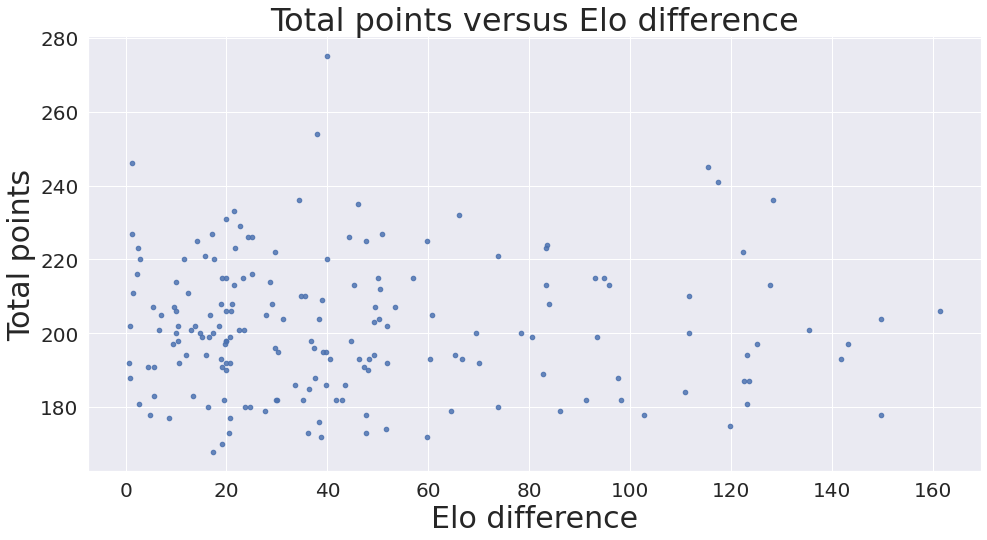

In [41]:
plt.figure(figsize=(16, 8))
nba_games_15_16.loc[nba_games_15_16['ELODIFF']!=0].plot.scatter(x="PROCESSED", y="COMBINED_FINAL_SCORE", alpha=0.6, ax=plt.gca())
plt.xlabel("Elo difference", fontsize=30)
plt.ylabel("Total points", fontsize=30)
plt.title("Total points versus Elo difference", fontsize=32)
plt.gca().tick_params(axis='both', which='major', labelsize=20)
plt.gca().tick_params(axis='both', which='minor', labelsize=20)
plt.show()

In [53]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(copy_X = True)

In [46]:
reg.fit(outcomes_df[['e','balance']],outcomes_df['score'])

LinearRegression()

In [47]:
pred = reg.predict(outcomes_df[['e','balance']])